---
title: "Project Working File"
execute:
  kernel: ad688-venv
bibliography: references.bib
csl: csl/econometrica.csl
format: 
  html:
    toc: true
    number-sections: true
    df-print: paged
---

## This file contains the code blocks for data cleaning, EDAs, skill gap analysis, NLP processing, etc. as a working file
## Each file that contributes to the overall quarto website will contain the text and visual outputs only. 


### Code block for data_cleaning.qmd: 

In [1]:
import pandas as pd

# Load lightcast_job_postings.csv 
df = pd.read_csv("data/lightcast_job_postings.csv")

# Show the first 5 rows 
print(df.head(5).to_string())



                                         ID LAST_UPDATED_DATE     LAST_UPDATED_TIMESTAMP  DUPLICATES    POSTED    EXPIRED  DURATION            SOURCE_TYPES                                        SOURCES                                                                                                                                                                                                                       URL ACTIVE_URLS ACTIVE_SOURCES_INFO                                                     TITLE_RAW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

/var/folders/y1/rx8hx7116f35w_wcxbtlb5m80000gn/T/ipykernel_47688/4123400745.py:4: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/lightcast_job_postings.csv")


In [2]:
# Drop columns
columns_to_drop = [
    # Meta/tracking
    "ID", "LAST_UPDATED_DATE", "LAST_UPDATED_TIMESTAMP", "DUPLICATES", "URL",
    "ACTIVE_URLS", "ACTIVE_SOURCES_INFO", "SOURCE_TYPES", "SOURCES",

    # Duplicated location info
    "LOCATION", "CITY", "STATE", "COUNTY", "COUNTY_NAME",
    "COUNTY_OUTGOING", "COUNTY_NAME_OUTGOING", "COUNTY_INCOMING", "COUNTY_NAME_INCOMING",
    "MSA", "MSA_OUTGOING", "MSA_NAME_OUTGOING", "MSA_INCOMING", "MSA_NAME_INCOMING",

    # Raw/duplicate title & body
    "TITLE_RAW", "TITLE_NAME",

    # Duplicated employment info
    "EMPLOYMENT_TYPE", "EMPLOYMENT_TYPE_NAME",

    # Education code columns
    "EDUCATION_LEVELS", "EDUCATION_LEVELS_NAME", "MIN_EDULEVELS", "MAX_EDULEVELS",

    # Redundant NAICS/SOC versions
    "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME", "NAICS4", "NAICS4_NAME",
    "NAICS5", "NAICS5_NAME", "NAICS6", "NAICS6_NAME",
    "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME", "SOC_4", "SOC_4_NAME",
    "SOC_5",  # keep SOC_5_NAME, drop code
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    "SOC_2021_4", "SOC_2021_4_NAME", "SOC_2021_5", "SOC_2021_5_NAME",

    # LOT/V6 occupation hierarchy (keep only 1 specialized name field)
    "LOT_CAREER_AREA", "LOT_CAREER_AREA_NAME", "LOT_OCCUPATION", "LOT_OCCUPATION_NAME",
    "LOT_OCCUPATION_GROUP", "LOT_OCCUPATION_GROUP_NAME",
    "LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_SPECIALIZED_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION", "LOT_V6_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION_GROUP", "LOT_V6_OCCUPATION_GROUP_NAME",
    "LOT_V6_CAREER_AREA", "LOT_V6_CAREER_AREA_NAME",

    # ONET & CIP codes (unless you're doing deep labor mapping)
    "ONET", "ONET_NAME", "ONET_2019", "ONET_2019_NAME",
    "CIP2", "CIP2_NAME", "CIP4", "CIP4_NAME", "CIP6", "CIP6_NAME",

    # Sectors
    "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME",

    # NAICS 2022 lower-level codes
    "NAICS_2022_2", "NAICS_2022_2_NAME", "NAICS_2022_3", "NAICS_2022_3_NAME",
    "NAICS_2022_4", "NAICS_2022_4_NAME", "NAICS_2022_5", "NAICS_2022_5_NAME",
    "NAICS_2022_6",  # drop code, keep name
]

df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72498 entries, 0 to 72497
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   POSTED                           72476 non-null  object 
 1   EXPIRED                          64654 non-null  object 
 2   DURATION                         45182 non-null  float64
 3   BODY                             72454 non-null  object 
 4   MODELED_EXPIRED                  57082 non-null  object 
 5   MODELED_DURATION                 53208 non-null  float64
 6   COMPANY                          72454 non-null  float64
 7   COMPANY_NAME                     72454 non-null  object 
 8   COMPANY_RAW                      71957 non-null  object 
 9   COMPANY_IS_STAFFING              72454 non-null  object 
 10  MIN_EDULEVELS_NAME               72454 non-null  object 
 11  MAX_EDULEVELS_NAME               16315 non-null  object 
 12  MIN_YEARS_EXPERIEN

In [ ]:

# Drop columns
#columns_to_drop = [
  # tracking & other metadata
    #"ID", "LAST_UPDATED_DATE", "LAST_UPDATED_TIMESTAMP", "DUPLICATES",
    #"SOURCE_TYPES", "SOURCES", "URL", "ACTIVE_URLS", "ACTIVE_SOURCES_INFO", "MODELED_EXPIRED", "MODELED_DURATION", "TITLE_RAW",
  # outdated NAICS and SOC codes
    #"NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME",
    #"NAICS4", "NAICS4_NAME", "NAICS5", "NAICS5_NAME",
    #"NAICS6", "NAICS6_NAME", 
    #"SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME",
    #"SOC_4", "SOC_4_NAME", "SOC_5", "SOC_5_NAME",
    #"SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    #"SOC_2021_5", "SOC_2021_5_NAME",
    #"NAICS_2022_2", "NAICS_2022_2_NAME", "NAICS_2022_3", "NAICS_2022_3_NAME",
    #"NAICS_2022_4", "NAICS_2022_4_NAME", "NAICS_2022_5", "NAICS_2022_5_NAME"
#]
#df.drop(columns=columns_to_drop, inplace=True)
#df.info()

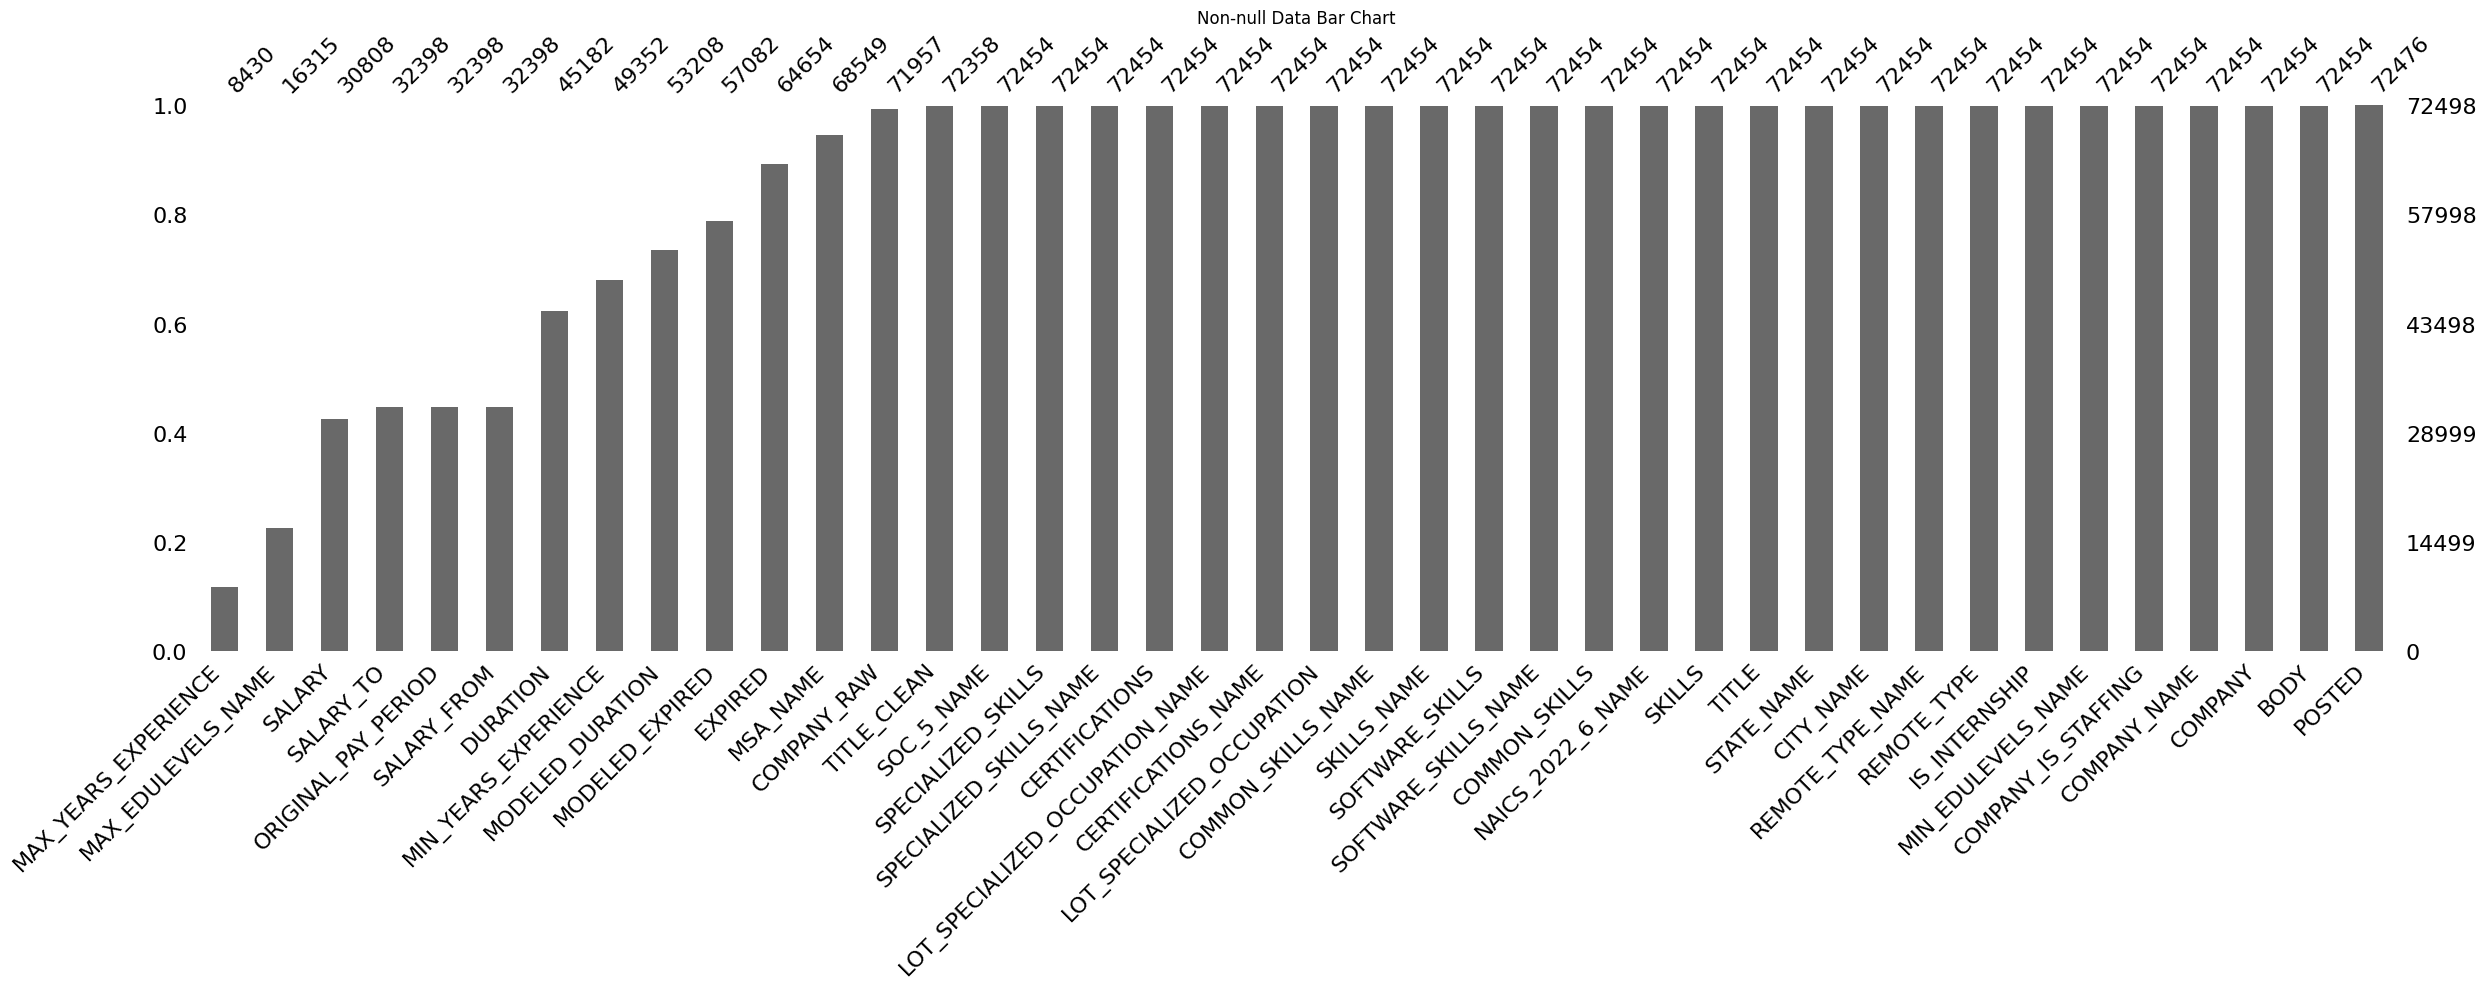

                         Column  Missing %
           MAX_YEARS_EXPERIENCE  88.372093
             MAX_EDULEVELS_NAME  77.495931
                         SALARY  57.505035
                      SALARY_TO  55.311871
            ORIGINAL_PAY_PERIOD  55.311871
                    SALARY_FROM  55.311871
                       DURATION  37.678281
           MIN_YEARS_EXPERIENCE  31.926398
               MODELED_DURATION  26.607631
                MODELED_EXPIRED  21.264035
                        EXPIRED  10.819609
                       MSA_NAME   5.447047
                    COMPANY_RAW   0.746227
                    TITLE_CLEAN   0.193109
                     SOC_5_NAME   0.060691
             SPECIALIZED_SKILLS   0.060691
        SPECIALIZED_SKILLS_NAME   0.060691
                 CERTIFICATIONS   0.060691
LOT_SPECIALIZED_OCCUPATION_NAME   0.060691
            CERTIFICATIONS_NAME   0.060691
     LOT_SPECIALIZED_OCCUPATION   0.060691
             COMMON_SKILLS_NAME   0.060691
           

In [3]:
import missingno as msno
import matplotlib.pyplot as plt

# Identify columns that have a significant amount of missing values and sort df by the percentage of missing values
missing_percent = df.isnull().mean().sort_values(ascending=False)*100
df_sorted = df[missing_percent.index]

# Visualize missing data using missingno bar chart 
plt.figure(figsize=(12, 6))
msno.bar(df_sorted)
plt.title("Non-null Data Bar Chart")
plt.tight_layout()
out_path = "figures/non-null_data.png"
plt.savefig(out_path, dpi=150)
plt.show()

missing_values_pct = (missing_percent.reset_index().rename(columns={"index": "Column", 0: "Missing %"}))
print(missing_values_pct.to_string(index=False))


In [4]:
# Drop columns with >50% missing values
cols_to_drop_missing = [
    "MAX_YEARS_EXPERIENCE",
    "MAX_EDULEVELS_NAME",
    "SALARY_FROM",
    "SALARY_TO",
    "ORIGINAL_PAY_PERIOD",
    "MODELED_DURATION",
    "MODELED_EXPIRED",
    "EXPIRED"
]
df.drop(columns=cols_to_drop_missing, inplace=True)

# Fill categorical columns with "Unknown"
fill_col_unk = [
    # Company info
    "COMPANY_NAME", "COMPANY_IS_STAFFING",
    
    # Job titles
    "TITLE", "TITLE_CLEAN",
    
    # Occupation/industry (kept name fields)
    "SOC_5_NAME", "LOT_SPECIALIZED_OCCUPATION_NAME", "NAICS_2022_6_NAME",
    
    # Remote type
    "REMOTE_TYPE_NAME",
    
    # Education level (names, not codes)
    "MIN_EDULEVELS_NAME", 
    
    # Location info
    "STATE_NAME", "CITY_NAME", "MSA_NAME",
    
    # Skills/certifications (optional — only if you plan to analyze skills)
    "SKILLS_NAME", "SPECIALIZED_SKILLS_NAME", "COMMON_SKILLS_NAME", "CERTIFICATIONS_NAME"
]

# Loop through and fill missing values
for col in fill_col_unk:
    df[col] = df[col].fillna("Unknown")

# Create a cleaned version for SALARY with median imputation
df["SALARY_CLEANED"] = df["SALARY"].copy()
median_salary = df["SALARY"].median()
df["SALARY_CLEANED"] = df["SALARY_CLEANED"].fillna(median_salary)

# Drop columns with >50% missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72498 entries, 0 to 72497
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   POSTED                           72476 non-null  object 
 1   DURATION                         45182 non-null  float64
 2   BODY                             72454 non-null  object 
 3   COMPANY                          72454 non-null  float64
 4   COMPANY_NAME                     72498 non-null  object 
 5   COMPANY_RAW                      71957 non-null  object 
 6   COMPANY_IS_STAFFING              72498 non-null  object 
 7   MIN_EDULEVELS_NAME               72498 non-null  object 
 8   MIN_YEARS_EXPERIENCE             49352 non-null  float64
 9   IS_INTERNSHIP                    72454 non-null  object 
 10  SALARY                           30808 non-null  float64
 11  REMOTE_TYPE                      72454 non-null  float64
 12  REMOTE_TYPE_NAME  

In [5]:
# Remove duplicate
df=df.drop_duplicates(subset=["TITLE_CLEAN", "COMPANY_NAME", "POSTED", "REMOTE_TYPE_NAME", "SKILLS_NAME"], keep="first")

# Preview new df
df.shape

(55656, 33)

### Code block for eda.qmd: 
#### 5.1.1 Salary by Remote Work Type

In [6]:
# 5.1.1 Visual - Compensation
import plotly.express as px
import pandas as pd

values_to_exclude = ['Unknown', '[None]']
df_filtered = df[~df['REMOTE_TYPE_NAME'].isin(values_to_exclude)]

fig1 = px.box(
    df_filtered,
    x="REMOTE_TYPE_NAME",
    y="SALARY",
    title="Salary Distribution by Work Arrangement",
    labels={"REMOTE_TYPE_NAME": "Work Arrangement", "SALARY": "Annual Salary ($)"}
)
fig1.show()
fig1.write_image("figures/salary_by_work_arrangement.png", scale=2)

#### 5.1.2 Top Skills vs. Average Salary

In [7]:
# 5.1.2 Visual - Skills vs. Salary
import plotly.express as px
import ast

# This function safely converts the string of a list into an actual list
def parse_skills(skill_list_str):
    try:
        return ast.literal_eval(skill_list_str)
    except (ValueError, SyntaxError):
        return []

# Create a new column with the cleaned lists of skills
df['SKILLS_LIST'] = df['SKILLS_NAME'].apply(parse_skills)

# Create a new DataFrame where each skill gets its own row
df_skills_exploded = df.explode('SKILLS_LIST')

# --- Now, create the chart using the cleaned data ---
top_10_skills_by_count = df_skills_exploded['SKILLS_LIST'].value_counts().nlargest(10).index
df_top_skills = df_skills_exploded[df_skills_exploded['SKILLS_LIST'].isin(top_10_skills_by_count)]

avg_salary_for_top_skills = df_top_skills.groupby('SKILLS_LIST')['SALARY'].mean().reset_index()

fig2 = px.bar(
    avg_salary_for_top_skills,
    x='SKILLS_LIST',
    y="SALARY",
    title="Average Salary for Top 10 Skills",
    labels={'SKILLS_LIST': "Skill", "SALARY": "Average Annual Salary ($)"}
)
fig2.show()
fig2.write_image("figures/topskills_salary.png", scale=2)

#### 5.1.3 Salary Distribution by Top Industries

/var/folders/y1/rx8hx7116f35w_wcxbtlb5m80000gn/T/ipykernel_47688/3990663221.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/y1/rx8hx7116f35w_wcxbtlb5m80000gn/T/ipykernel_47688/3990663221.py:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




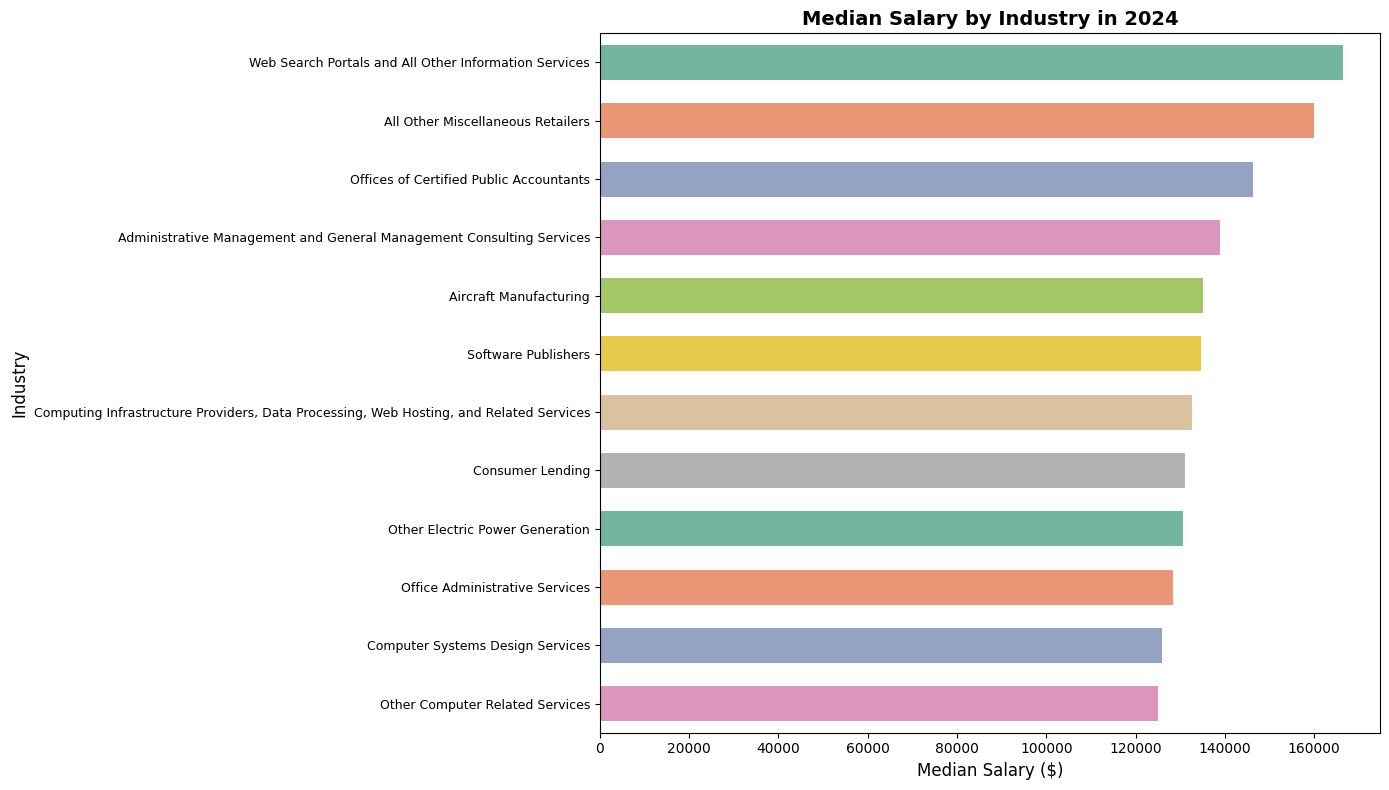

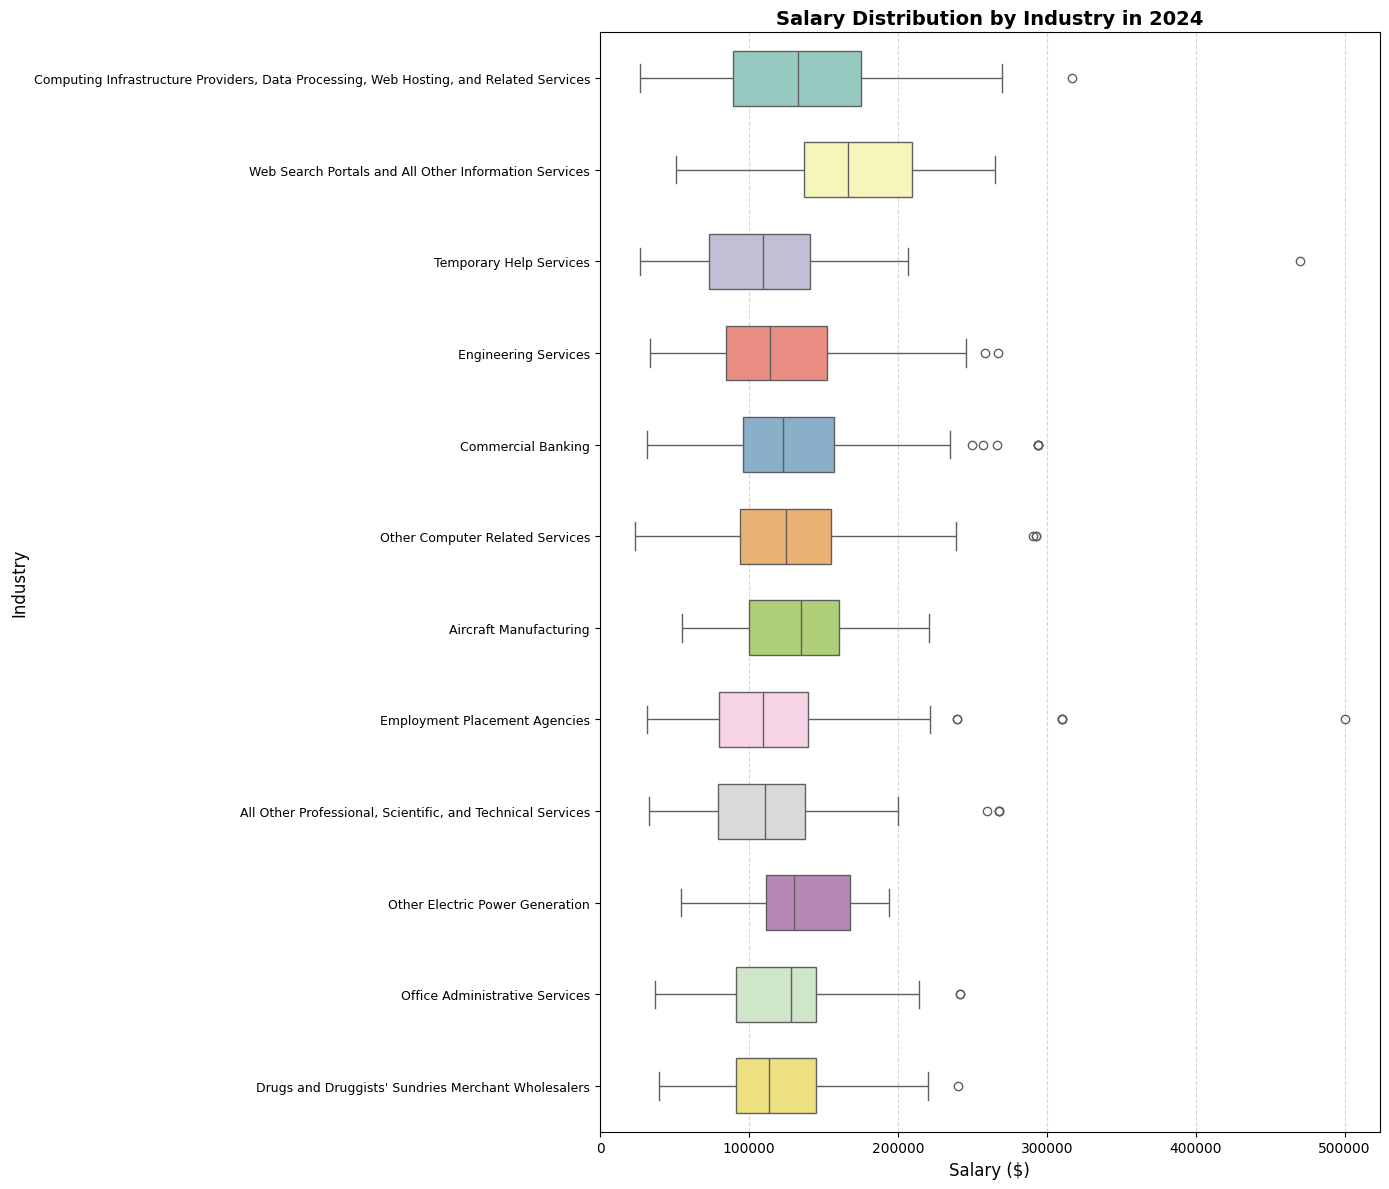

In [8]:
## Query Setup
# Convert the POSTED date from string to date format
df["POSTED"] = pd.to_datetime(df["POSTED"], errors="coerce")

# Filter for job postings from 2024, specifically looking at Salary and Industry. Exclude unknowns, nulls, and zeros. Exclude 'Unclassified Industry' 
df_jp_2024 = df[
  (df["POSTED"].dt.year==2024) & 
  (df["SALARY"] > 0) & 
  (df["SALARY"].notnull()) &
  (df["NAICS_2022_6_NAME"]!= "Unknown") &
  (df["NAICS_2022_6_NAME"]!= "Unclassified Industry")
]

## Further filter to exclude industries that have an insignificant number of job postings
# count the number of rows per industry  
industry_jp_count = df_jp_2024["NAICS_2022_6_NAME"].value_counts()

# summarize the distribution of job counts per industry
industry_jp_count.describe()

# Set minimum threshold at 100 job postings to ensure statistical significance
top_jp_industries = industry_jp_count[industry_jp_count > 100].index

# Update df to only show top job posting industries
df_jp_2024 = df_jp_2024[df_jp_2024["NAICS_2022_6_NAME"].isin(top_jp_industries)]

## Plot: Analyze Median Salary by Industry (Seaborn)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# group by industry name and calculate median salary, sort by descending order
top_industry_salary_order = df_jp_2024.groupby("NAICS_2022_6_NAME")["SALARY"].median().sort_values(ascending=False).head(12).index

# create bar chart
plt.figure(figsize = (14,8))
sns.barplot(
  orient='h',
  data=df_jp_2024,
  x="SALARY",
  y="NAICS_2022_6_NAME",
  order=top_industry_salary_order,
  palette="Set2",
  width=0.6,
  estimator=np.median,
  errorbar=None
)
plt.title("Median Salary by Industry in 2024", fontsize=14, weight="bold")
plt.xlabel("Median Salary ($)", fontsize=12)
plt.ylabel("Industry", fontsize=12)
plt.yticks(ha="right", fontsize=9)
plt.tight_layout()
plt.show
out_path = "figures/median_salary_by_industry.png"
plt.savefig(out_path, dpi=150)

## Plot: Analyze Salary Distribution by Industry (Seaborn)
# determine IQRs by industry:
q25 = df_jp_2024.groupby("NAICS_2022_6_NAME")["SALARY"].quantile(0.25)
q75 = df_jp_2024.groupby("NAICS_2022_6_NAME")["SALARY"].quantile(0.75)
# sort by the middle 50% (Q3 - Q1) and name that as the new sorting order
iqr = (q75 - q25).sort_values(ascending=False).head(12)
iqr_order = iqr.index  

# Create box plot
plt.figure(figsize=(14, 12))
sns.boxplot(
  data=df_jp_2024,
  y="NAICS_2022_6_NAME",
  x="SALARY",
  order=iqr_order,
  palette="Set3",
  width=0.6
)
plt.title("Salary Distribution by Industry in 2024", fontsize=14, weight="bold")
plt.ylabel("Industry", fontsize=12)
plt.xlabel("Salary ($)", fontsize=12)
plt.yticks(ha="right", fontsize=9)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show
out_path = "figures/salary_distribution_by_industry.png"
plt.savefig(out_path, dpi=150)

#### 5.1.4 AI vs. Non-AI Job Salary Comparison

In [10]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Create a lowercase version of the BODY column for keyword searching
df["BODY"] = df["BODY"].astype(str).str.lower()

# identify AI related keywords 
ai_keywords = [
    "machine learn",  # matches 'machine learning', 'machine learner'
    "data scien",     # matches 'data scientist', 'data science'
    "artificial intel",  # matches 'artificial intelligence'
    "deep learn",  
    "ml engineer",            
    "data engineer",
    "computer vision",
    "natural language",
    "nlp",
    "big data",
    "cloud data"   
]

# Create a regex pattern that matches any of the keywords, case-insensitive
ai_pattern = re.compile(r"|".join([re.escape(k) for k in ai_keywords]), flags=re.IGNORECASE)

# Assign a new column is_ai_job to label job postings with AI or Non-AI based on keyword presence in the BODY text
df["is_ai_job"] = df["BODY"].apply(lambda text: "AI" if ai_pattern.search(text) else "Non-AI")

# Filter out rows with null or zero salary and outliers 
df_filtered_1 = df[
    (df["SALARY"].notnull()) &
    (df["SALARY"] > 0)
]
q1 = df_filtered_1["SALARY"].quantile(0.01)
q99 = df_filtered_1["SALARY"].quantile(0.99)
df_filtered_1 = df_filtered_1[(df_filtered_1["SALARY"] >= q1) & (df_filtered_1["SALARY"] <= q99)]

print(df_filtered_1["is_ai_job"].value_counts())


is_ai_job
Non-AI    15948
AI         5273
Name: count, dtype: int64


In [ ]:
#print("Original:", len(df))
#print("Filtered:", len(df_filtered_1))

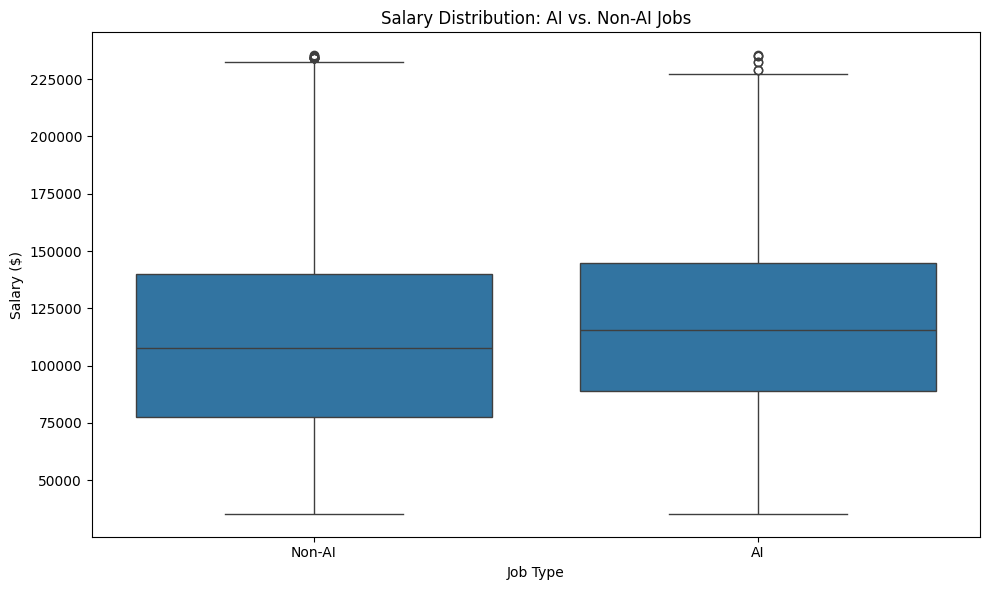

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered_1, x="is_ai_job", y="SALARY")
plt.title("Salary Distribution: AI vs. Non-AI Jobs")
plt.xlabel("Job Type")
plt.ylabel("Salary ($)")
plt.tight_layout()
plt.show()
out_path = "figures/AI_v_nonAI_salary_boxplot.png"
plt.savefig(out_path, dpi=150)

In [ ]:
# 
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_filtered_1, x="SALARY", hue="is_ai_job", common_norm=False)
plt.title("Salary Density: AI vs. Non-AI Jobs")
plt.xlabel("Salary ($)")
plt.tight_layout()
plt.show()

In [ ]:
# ----- Export All Charts -----
import plotly.express as px
import ast

fig1.write_image("chart1_salary_by_work_type.png")
fig2.write_image("chart2_skills_vs_salary.png")

print("fig1 and fig2 have been saved as PNG files.")

### code block for skill_gap_analysis.qmd: 
#### Team-based Skill Dataframe

In [ ]:
# Create list of relevant analytics skills and rate each member from 1-5
import pandas as pd

skills_data = {
    "Name": ["Angelina", "Devin", "Leo"],
    "Python": [3, 1, 3],
    "SQL": [3, 3, 3],
    "Power BI": [5, 4, 4],
    "Tableau": [4, 3, 2],
    "Excel": [5, 5, 4],
    "Machine Learning": [2, 1, 1],
    "NLP": [2, 1, 1],
    "Cloud Computing": [1, 2, 1],
    "AWS": [1, 1, 1]
}

# Convert to dataframe 
df_skills = pd.DataFrame(skills_data)
df_skills.set_index("Name", inplace=True)
df_skills

# Plot df as a heatmap to visualize skill distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_skills, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Team Skill Levels Heatmap")
plt.show()

#### Compare team skills to industry requirements
#### NLP Processing Code Block

In [ ]:
## Extract most in-demand skills from JD 

import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from pathlib import Path
import nltk

nltk.data.path.append(str(Path.home() / "nltk_data"))

stop_words = stopwords.words("english")

# Pull description from job postings and convert into strings
job_descriptions = df["BODY"].dropna().astype(str).tolist()

## NLP processing
# Combine all JD strings into one string and convert all to lowercase 
print("Combining job descriptions...")
all_text = " ".join(job_descriptions).lower()

# Extract only alphabetical and excludes punctuation, numeric values, symbols (Tokenizing)
print("Running regex to extract words...")
words = re.findall(r'\b[a-zA]+\b', all_text)

# Filter to remove common stopwords 
print("Filtering out stopwords...")
words_filtered = [word for word in words if word not in stopwords.words("english")]

# Count the frequency of each word
print("Counting word frequencies...")
words_count = Counter(words_filtered)

# Define a list of skills: 
skills_list = {"python", "sql", "aws", "docker", "tableau", "excel", "pandas", "numpy", "power", "spark", "machine", "learning", "nlp", "cloud", "computing"}

# Extract the predefined skills that actually appear in the job postings text blob; 
skills_filtered = {
  skill: words_count[skill]
  for skill in skills_list
  if skill in words_count
}

print("Top data analytics skills from job description")
for skill, count in skills_filtered.items():
  print(f"{skill}:{count}")